# VIMS Spectra
This notebook extracts the Cassini VIMS spectra of scenes near Enceladus during the bright band observations in flyby E17

In [23]:
from scripts.project_defs import *
from scipy import ndimage

Define scenes, extract average spectra, and combine over all observations.

Cube name: 1711545954_1
Cube mid-time: 2012-03-27 12:36:52.718500+00:00


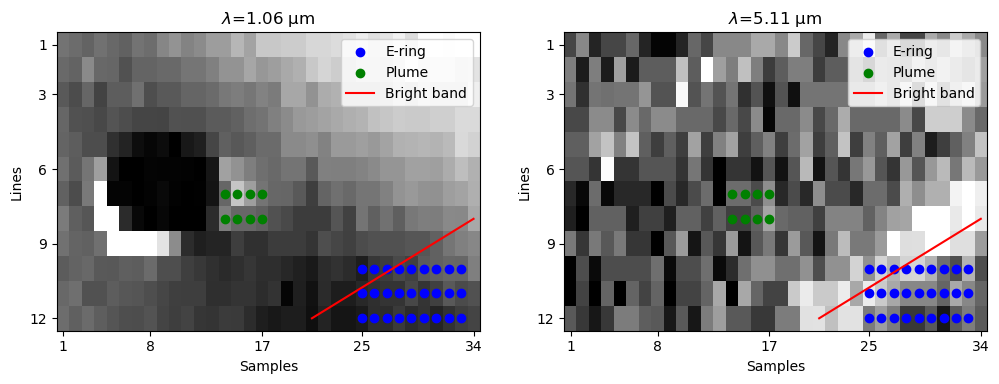

Cube name: 1711546301_1
Cube mid-time: 2012-03-27 12:42:40.480500+00:00


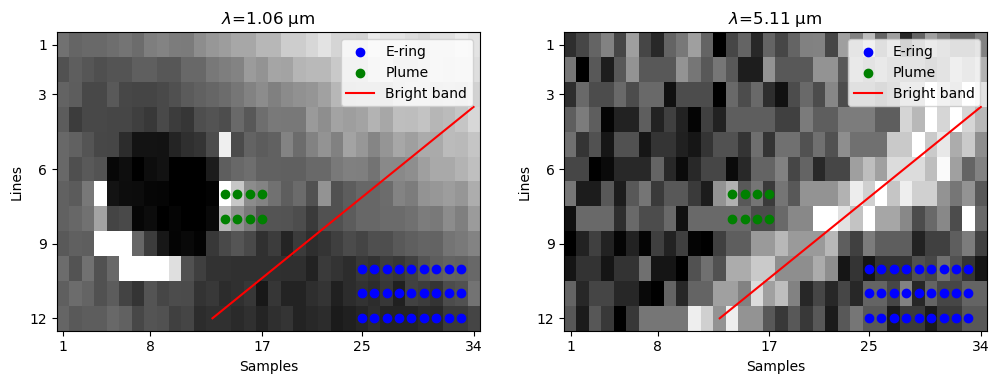

Cube name: 1711546589_1
Cube mid-time: 2012-03-27 12:47:27.714500+00:00


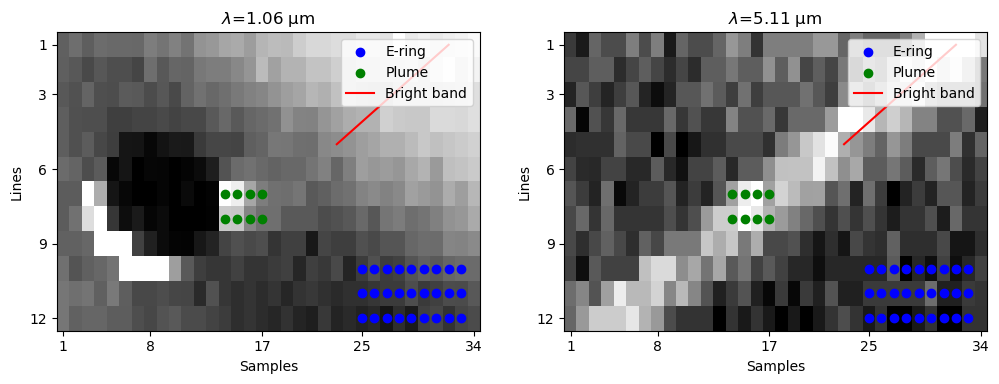

Cube name: 1711546939_1
Cube mid-time: 2012-03-27 12:53:18.476500+00:00


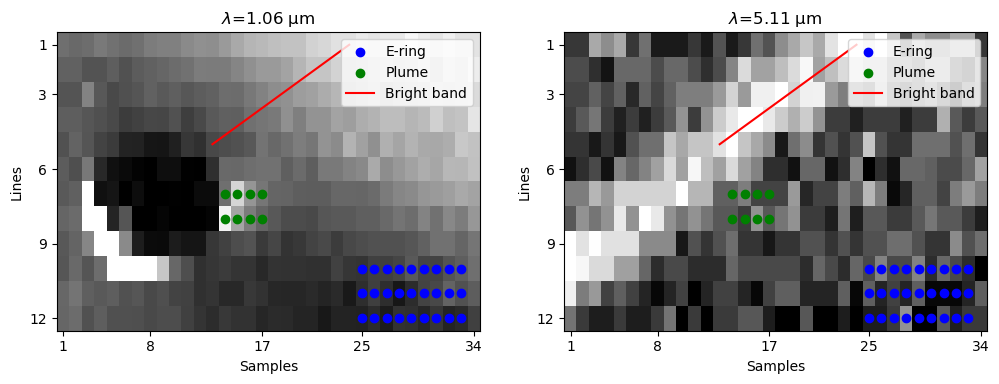

Cube name: 1711547227_1
Cube mid-time: 2012-03-27 12:58:05.730500+00:00


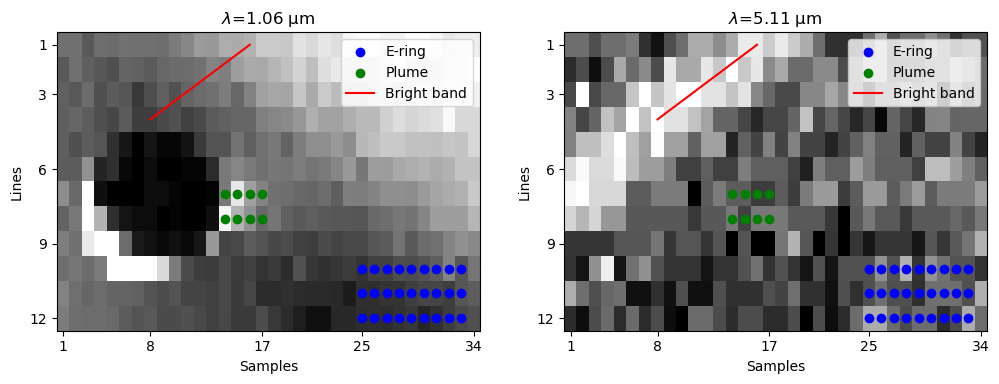

In [24]:
# cubes containing the bright band
CUBE_IDS = [
    #'1711545666_1',
    '1711545954_1',       # k=0
    '1711546301_1',       # k=1
    '1711546589_1',       # k=2
    '1711546939_1',       # k=3
    '1711547227_1',       # k=4
    # '1711547571_1'
]

CUBES = [VIMS(cube_id, root="../data/cubes/") for cube_id in CUBE_IDS]

# set up lists for spectra
bb_spec_comb = []
bg_spec_comb = []
plume_spec_comb = []
dark_spec_comb = []
k = 0
for cube in CUBES:
    print(f'Cube name: {cube}')
    print(f'Cube mid-time: {cube.time}')
    # print(f'Exposure duration: {cube.expo}')
    # print(f"Interline delays: {cube.interline_delay}")
    # print(f'Cube data size: {cube.NB, cube.NL, cube.NS}')
    # print(f'Acquisition mode: {cube.mode}')

    data = cube.data
    wavelengths = cube.wvlns
    bg_cube =  np.ones((cube.NL, cube.NS))

    # select areas of interest
    # E-ring
    ering_pixels = pixels_in_rectangle(bg_cube, (25, 12 ), (35, 10))
    bg_spec_ering = calculate_average_spectrum(ering_pixels, cube)
    if k != 0:
        bg_spec_comb.append(bg_spec_ering)
    # Enceladus body
    ebody_pixels = pixels_in_rectangle(bg_cube, (6, 8), (11, 7))
    bg_spec_ebody = calculate_average_spectrum(ebody_pixels, cube)
    if k != 3:
        dark_spec_comb.append(bg_spec_ebody)
    # plume
    plume_pixels = pixels_in_rectangle(bg_cube, (14, 8), (17, 7))
    bg_spec_plume = calculate_average_spectrum(plume_pixels, cube)
    if k != 2:
        plume_spec_comb.append(bg_spec_plume)

    # coordinates for the bright band line
    if k == 0:
        x0, y0 = 21, 12
        x1, y1 = 34, 8
    if k == 1:
        x0, y0 = 13, 12
        x1, y1 = 34, 3.5
    if k == 2:
        x0, y0 = 23, 5
        x1, y1 = 32, 1
    if k == 3:
        x0, y0 = 13, 5
        x1, y1 = 24, 1
    if k == 4:
        x0, y0 = 8, 4
        x1, y1 = 16, 1

    # show data extraction coverage
    ii = [10, 254]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    for idx, i in enumerate(ii):
        cup = data[i, :, :]
        # Get aspect ratio of cube
        aspect_ratio = 2
        # Calculate range for colorbar (excluding outliers)
        vmin, vmax = calculate_percentiles(cup)
        extent = cube.extent

        ax = axes[idx]
        im = ax.imshow(cup, extent=cube.extent, cmap='gray', vmin=vmin, vmax=vmax, aspect=aspect_ratio)

        # Scatter plots with unique labels for the legend
        ax.scatter(ering_pixels[:, 0], ering_pixels[:, 1], c="blue", label="E-ring")
        # ax.scatter(ebody_pixels[:, 0], ebody_pixels[:, 1], c="red", label="E-body")
        ax.scatter(plume_pixels[:, 0], plume_pixels[:, 1], c="green", label="Plume")
        # line for bright band sampling
        ax.plot([x0, x1], [y0, y1], color='red', label="Bright band")

        ax.set_xlabel(cube.slabel)
        ax.set_ylabel(cube.llabel)
        ax.set_title(f"$\lambda$={cube.wvlns[i]:.2f} μm")
        ax.set_xticks(cube.sticks)
        ax.set_yticks(cube.lticks)
        ax.legend(loc="upper right")

    plt.show()

    # Extract I/F over sample line
    # Calculate the number of points along the line
    num_points = int(np.hypot(x1 - x0, y1 - y0))
    x, y = np.linspace(x0, x1, num_points), np.linspace(y0, y1, num_points)

    # List to store average intensity values for each wavelength
    average_intensity_values = []
    central_lams = []
    # loop over every wavelength channel
    for i in range(256):
        cup = data[i, :, :]
        lam = cube.wvlns[i]
        vmin, vmax = calculate_percentiles(cup)
        central_lams.append(lam)

        # Sample the intensity values along the line
        intensity_values = ndimage.map_coordinates(cup, [y, x], order=3)

        # Calculate the average intensity along the line
        avg_intensity = np.mean(intensity_values)
        average_intensity_values.append(avg_intensity)

    # save to bb combined list
    bb_spec_comb.append(np.array(average_intensity_values))

    # remove bad pixels
    bad_pix_mask = remove_bad_pix(cube)
    k += 1

# compute average spectra over every cube
bb_comb = np.mean(np.array(bb_spec_comb), axis=0)
bg_comb = np.mean(np.array(bg_spec_comb), axis=0)
plume_comb = np.mean(np.array(plume_spec_comb), axis=0)
dark_comb = np.mean(np.array(dark_spec_comb), axis=0)
bb_min_bg = bb_comb-bg_comb
bb_div_bg = bb_comb/bg_comb

Plot average spectra of combined observations for each scene.

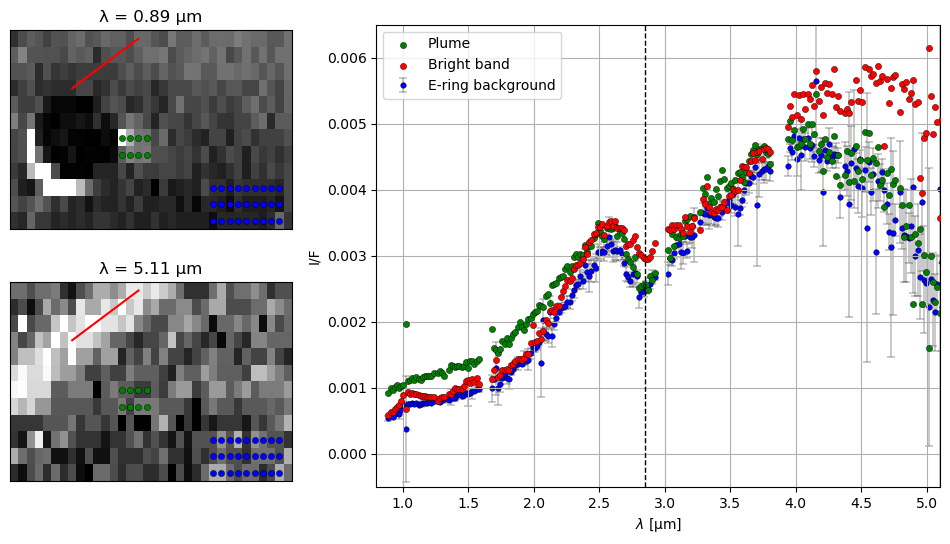

In [25]:
# smoothing window
w_smooth = 5
# smooth spectra
smooth_lams = moving_average(central_lams, w_smooth)
# smooth_intensity = moving_average(bb_div_bg, w_smooth)
smooth_intensity = moving_average(bb_comb, w_smooth)

# Compute the standard deviation for e-ring background (according to Dhingra et al., 2017)
bg_std = np.std(np.array(bg_spec_comb), axis=0)

# set-up plot with example cube
cube= CUBES[-1]
data = cube.data
i = 0
cup = data[i, :, :]
lam = cube.wvlns[i]
vmin, vmax = calculate_percentiles(cup)

# figure
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1], wspace=0.2)

# first image plot (i=0) on the top-left
ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(cup, extent=cube.extent, cmap='gray', vmin=vmin, vmax=vmax, aspect=2)
ax1.scatter(ering_pixels[:, 0], ering_pixels[:, 1], c="blue", label="E-ring pixels", s=20,
            edgecolors='black', linewidths=0.3)
# ax1.scatter(ebody_pixels[:, 0], ebody_pixels[:, 1], c="red", label="Body pixels")
ax1.scatter(plume_pixels[:, 0], plume_pixels[:, 1], c="green", label="Plume pixels", s=20,
            edgecolors='black', linewidths=0.3)
ax1.plot([x0, x1], [y0, y1], color='red')
ax1.set_title(f'λ = {np.round(lam,2)} µm')
ax1.set_xticks([])
ax1.set_yticks([])

# Second image plot (i=254) on the bottom-left
i = 254
cup = data[i, :, :]
lam = cube.wvlns[i]
vmin, vmax = calculate_percentiles(cup)
ax2 = fig.add_subplot(gs[1, 0])
ax2.imshow(cup, extent=cube.extent, cmap='gray', vmin=vmin, vmax=vmax, aspect=2)
ax2.scatter(ering_pixels[:, 0], ering_pixels[:, 1], c="blue", label="E-ring background pixels", s=20,
            edgecolors='black', linewidths=0.3)
# ax2.scatter(ebody_pixels[:, 0], ebody_pixels[:, 1], c="red", label="Body pixels")
ax2.scatter(plume_pixels[:, 0], plume_pixels[:, 1], c="green", label="Plume pixels", s=20,
            edgecolors='black', linewidths=0.3)
ax2.plot([x0, x1], [y0, y1], color='red')
ax2.set_title(f'λ = {np.round(lam,2)} µm')
ax2.set_yticks([])
ax2.set_xticks([])

# Spectra
ax3 = fig.add_subplot(gs[:, 1])  # Spans two rows (stacked vertically)
ax3.errorbar(np.array(central_lams)[bad_pix_mask], np.array(bg_comb)[bad_pix_mask],
             yerr=bg_std[bad_pix_mask], fmt='o', mfc='blue', mec='black',
             ecolor='black', label="E-ring background", capsize=3, markersize=4, elinewidth=0.3, mew=0.3, zorder=1)
ax3.scatter(np.array(central_lams)[bad_pix_mask], np.array(plume_comb)[bad_pix_mask], s=20,
            edgecolors='black', linewidths=0.3, label="Plume", color="green", zorder=2)
ax3.scatter(np.array(central_lams)[bad_pix_mask], np.array(bb_comb)[bad_pix_mask], s=20,
            color="red", edgecolors='black', linewidths=0.3, label="Bright band", zorder=3)
ax3.axvline(2.85, linestyle='dashed', color='black', lw=1)
ax3.set_xlabel(r'$\lambda$ [µm]')
ax3.set_ylabel('I/F')
ax3.set_xlim(0.80, 5.10)
ax3.set_ylim(-0.0005, 0.0065)
ax3.legend()
ax3.grid(True)
plt.show()